# 1. NESTML neuron models

---

## 1.1 General outline of NESTML

NESTML is a powerful and intuitive tool that allows us to define our own neuron and synapse models by writing the equations and conditions that drive their dynamics.


To define the models, NESTML requires different 'blocks', each one serving different functions:

- **Parameters**: variables that remain constant throughout the simulation.

- **Internals** (optional): constant helper variables that are derived from parameters.

- **State**: list of variables that change over time.

- **Input**: one or more input ports --> spikes or continuous inputs (e.g., currents)

- **Output**: defines which type of event the models sends (currently, only spiking output is supported)

- **Equations**: system of differential equations, with an arbitrary amount of equations, that contain derivatives of arbitrary order.

- **Update**: contains statements which are executed at every simulation steps

- **onReceive**: excecutes conditions when (spiking) inputs are received to the model

- **onCondition**: excecutes conditions (in general)


You can find more information at: https://nestml.readthedocs.io/en/latest/nestml_language/nestml_language_concepts.html



## 1.2 The Izhikevich neuron model

In this Jupyter Notebook we will write from scratch the Izhikevich neuron model [1] in NESTML, build it, and use it in a simple NEST simulation to see the different types of dynamics this model is able to reproduce.

The Izhikevich neuron is described by the following set of equations:

$$
\begin{cases}
    v' = 0.04v^2 + 5v + 140 - u + I \\
    u' = a(bv - u)
\end{cases}
$$

Where $v$ is the membrane potential and $u$ is the recovery variable. When the membrane potential reaches $30 mV$, the variables update following:

$$
\begin{cases}
    v \leftarrow c \\
    u \leftarrow u + d
\end{cases}
$$

The images below show the different combinations of the parameters $a$, $b$, $c$, and $d$ that allows us to reproduce different types of dynamics (images taken from [1]):

![title](images/izhikevich_params.png)

![title](images/izhikevich_dynamics.png)

## 1.3 PROS/CONS


[1] E. M. Izhikevich, "Simple model of spiking neurons," in IEEE Transactions on Neural Networks, vol. 14, no. 6, pp. 1569-1572, Nov. 2003, doi: 10.1109/TNN.2003.820440.

## 1.4 Creating the neuron model

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import nest
import numpy as np
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May  5 2025 12:54:52

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
neuron_model = """
model izhikevich_neuron:
    parameters:
        a real = 0.02             # Describes time scale of recovery variable
        b real = 0.2              # Sensitivity of recovery variable
        c mV = -50 mV             # After-spike reset value of V_m
        d real = 2.0              # After-spike reset value of U_m
        V_m_init mV = -65 mV      # Initial membrane potential
        V_min mV = -inf * mV      # Absolute lower value for the membrane potential.
        V_th mV = 30 mV           # Threshold potential

        # Constant external input current
        I_e pA = 0 pA

    state:
        V_m mV = V_m_init         # Membrane potential
        U_m real = b * V_m_init   # Membrane potential recovery variable

    equations:
        V_m' = (0.04 * V_m * V_m / mV + 5.0 * V_m + (140 - U_m) * mV + ((I_e + I_stim) * GOhm)) / ms
        U_m' = a * (b * V_m - U_m * mV) / (mV * ms)

    input:
        spikes <- spike
        I_stim pA <- continuous

    output:
        spike

    update:
        integrate_odes()

        # Add synaptic current
        V_m += spikes * mV * s

        # lower bound of membrane potential
        V_m = max(V_min, V_m)

    onCondition(V_m >= V_th):
        # threshold crossing
        V_m = c
        U_m += d
        emit_spike()
"""

## 1.5 Building and installing the model in NEST

In [3]:
module_name, neuron_model_name = NESTCodeGeneratorUtils.generate_code_for(neuron_model)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May  5 2025 12:54:52

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[10,izhikevich_neuron_nestml, WARNING, [4:8;4:17]]: Variable 'a' has the same name as a physical unit!
[11,izhikevich_neuron_nestml, WARNING, [7:8;7:17]]: Variable 'd' has the same name as a physical unit!


## 1.6 Creating, simulating and visualising the neurons

In [ ]:
# [a, b, c, d]
params_dict = {
    "RS": [0.02, 0.2, -65, 8],    # Regular spiking
    "IB": [0.02, 0.2, -55, 4],
    "CH": [0.02, 0.2, -50, 2],
    "FS": [0.1, 0.2, -65, 2],
    "TC": [0.2, 0.25, -65, 0.05],
    "RZ": [0.1, 0.26, -65, 2],
    "LTS": [0.02, 0.25, -65, 2]
}


Aug 07 15:03:05 Install [Info]: 
    loaded module nestml_6d1badef3def408cb386ff5067b503a3_module

Aug 07 15:03:05 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Aug 07 15:03:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 07 15:03:05 SimulationManager::run [Info]: 
    Simulation finished.

Aug 07 15:03:05 Install [Info]: 
    loaded module nestml_6d1badef3def408cb386ff5067b503a3_module

Aug 07 15:03:05 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Aug 07 15:03:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 07 15:03:05 SimulationManager::run [Info]: 
    Simulation finished.

Aug 07 15:03:05 Install [Info]: 
    loaded module nestml_6d1badef3def408cb386ff5067b503a3_module

Aug 07 15:03:05 NodeManager::p

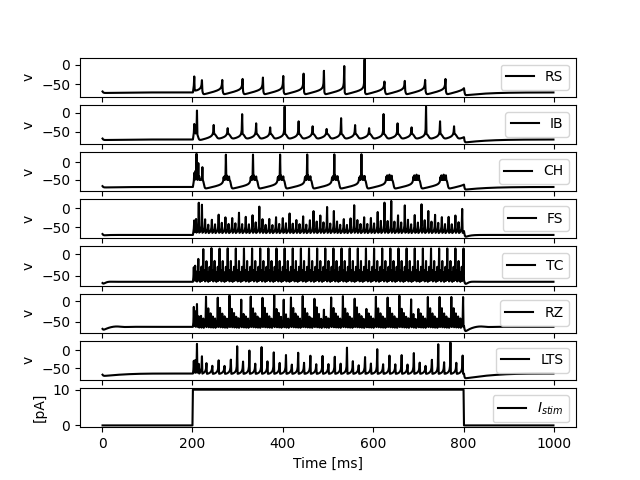

In [5]:
fig, ax = plt.subplots(len(params_dict) + 1, 1, sharex=True)

for i, (model, params) in enumerate(params_dict.items()):
    nest.ResetKernel()
    nest.Install(module_name)

    neuron = nest.Create(neuron_model_name, params={"a": params[0],
                                                    "b": params[1],
                                                    "c": params[2],
                                                    "d": params[3]})
    multi = nest.Create("multimeter", params={"record_from": ["V_m"]})
    current = nest.Create("step_current_generator", params={"amplitude_times": [200, 800],
                                                            "amplitude_values": [10, 0]})
    
    nest.Connect(multi, neuron)
    nest.Connect(current, neuron)
    nest.Simulate(1000)
    
    events = multi.get()["events"]
    V_m = events["V_m"]
    time = events["times"]

    ax[i].plot(time, V_m, color='k', label=f"{model}")
    ax[i].set_ylabel("v")
    ax[i].legend()

current_step = np.zeros((len(time)))
current_step[200:800] = 10
ax[-1].plot(time, current_step, color='k', label="$I_{stim}$")
ax[-1].set_ylabel("[pA]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()